# **Load necessary package**

In [1]:
import os 
import pandas as pd #Data Manipulation
import numpy as np #Data Manipulation
import matplotlib as matlib #Data Visulization (Correlations, etc)
import matplotlib.pyplot as plt
import seaborn as sns #Data Visulization (Correlations, etc)

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,None,pyspark,idle,,,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# **Loading data**
#### Set project directory path

In [2]:
# Set a path to your drive  

# my data is stored in "nfldata/pbp"
project_dir = "jupyter_workspace"

# You can explore the different folders using 
# `os.listdir()`
# create list of directories
szn_folders = os.listdir(f"{project_dir}/nfldata/pbp")
print(szn_folders)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['2022', '2023', '.DS_Store', '2019', '2021', '2020', '2018']

#### Create list of csv for import from source folders list

In [3]:
# NFL Play by Play Data
# https://github.com/nflverse/nflverse-data/releases/tag/pbp

# Within each season folder is a play-by-play CSV
# We'll need this to create our ML model 
# Let's just take seasons 2020-2022:  
target_seasons = [x for x in szn_folders 
                  if ('2020' in x) | 
                  ('2021' in x) | 
                  ('2022' in x)]

# This list comprehension navigates to the season 
# folder and selects the play-by-play filename and 
# appends it to a full path name
data_files = ([f"""{project_dir}/nfldata/pbp/{data_folder}/{os.listdir(f"{project_dir}/nfldata/pbp/{data_folder}")[0]}""" 
               for data_folder in target_seasons])

print(data_files)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['jupyter_workspace/nfldata/pbp/2022/play_by_play_2022.csv', 'jupyter_workspace/nfldata/pbp/2021/play_by_play_2021.csv', 'jupyter_workspace/nfldata/pbp/2020/play_by_play_2020.csv']

#### Loop list and add csv PBP data into DataFrame to work with

In [4]:
# We can open these data with pandas in a for loop
# Define width and columns to display
pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 800)
# initialize a dataframe to append data into
df = pd.DataFrame()

# loop through your filenames, open them, 
# and concat them to the df 
for fn in data_files: 
  df = pd.concat([df,pd.read_csv(fn,low_memory=False)])

# reset the index; each CSV comes in with its own
# index which causes duplicate indicies in a load
# like this 
df = df.reset_index(drop=True)  

# print the size of the dataframe
print(df.shape)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(149373, 372)

In [5]:
# show the top 10 results
df.head(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   play_id          game_id  old_game_id home_team  ... xyac_success   xyac_fd     xpass    pass_oe
0        1  2022_01_BAL_NYJ   2022091107       NYJ  ...          NaN       NaN       NaN        NaN
1       43  2022_01_BAL_NYJ   2022091107       NYJ  ...          NaN       NaN       NaN        NaN
2       68  2022_01_BAL_NYJ   2022091107       NYJ  ...          NaN       NaN  0.440373 -44.037291
3       89  2022_01_BAL_NYJ   2022091107       NYJ  ...     0.606930  0.227598  0.389904  61.009598
4      115  2022_01_BAL_NYJ   2022091107       NYJ  ...          NaN       NaN  0.443575 -44.357494
5      136  2022_01_BAL_NYJ   2022091107       NYJ  ...          NaN       NaN  0.963242   3.675753
6      172  2022_01_BAL_NYJ   2022091107       NYJ  ...          NaN       NaN       NaN        NaN
7      202  2022_01_BAL_NYJ   2022091107       NYJ  ...     0.606959  0.241949  0.479318  52.068213
8      230  2022_01_BAL_NYJ   2022091107       NYJ  ...     0.652492  0.514376  0.608057  39.194345


In [6]:
# show a random sample of 5 rows 
df.sample(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        play_id          game_id  old_game_id home_team  ... xyac_success   xyac_fd     xpass    pass_oe
18018      4421    2022_07_KC_SF   2022102310        SF  ...     0.601288  0.225401  0.883241  11.675882
116728     1290   2020_06_KC_BUF   2020101901       BUF  ...     0.396213  0.396213  0.981605   1.839489
20840      2540   2022_08_NE_NYJ   2022103007       NYJ  ...          NaN       NaN  0.478537 -47.853661
140739     3289  2020_15_PIT_CIN   2020122100       CIN  ...          NaN       NaN  0.406556 -40.655571
127622      348   2020_11_ATL_NO   2020112206        NO  ...          NaN       NaN       NaN        NaN

[5 rows x 372 columns]

In [8]:
# list all columns in the dataframe 
# df.columns.values

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## **Explore features**
#### What correlates with touchdowns?
#### Use yards and previous season performance to predict touchdowns?

In [9]:
# Although this dataset has a lot of different
# features, you most likely don't need to use
# all of them to create your first predictive 
# model. We should start simple with things that
# correlate with quarterback touchdowns 

# Let's take some basic quarterback stats 
qb_feats = ['season', 'passer_id', 'passer', 'pass', 
            'complete_pass', 'interception', 'sack', 
            'yards_gained', 'rush_touchdown', 'pass_touchdown']

# Let's group by season and who the passer was 
groupby_feats = ['season', 'passer_id', 'passer'] 

# group by and aggregate by sum 
# 
qb_df = (df
         .loc[df['season_type'] == 'REG', qb_feats]
         .groupby(groupby_feats, 
                  as_index=False)
         .sum())

qb_df['touchdowns'] = 0
qb_df['touchdowns'] = qb_df['rush_touchdown'] + qb_df['pass_touchdown']

# random sample of 10 player-seasons 
qb_df.sort_values(['season','touchdowns'], ascending=False).head(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     season   passer_id        passer  pass  ...  yards_gained  rush_touchdown  pass_touchdown  touchdowns
291    2022  00-0033873     P.Mahomes   765  ...        5412.0             4.0            41.0        45.0
305    2022  00-0034857       J.Allen   687  ...        4629.0             2.0            35.0        37.0
333    2022  00-0036442      J.Burrow   719  ...        4425.0             1.0            35.0        36.0
257    2022  00-0029604     K.Cousins   741  ...        4333.0             1.0            29.0        30.0
260    2022  00-0030565       G.Smith   692  ...        4240.0             0.0            30.0        30.0
279    2022  00-0033106        J.Goff   661  ...        4363.0             0.0            29.0        29.0
242    2022  00-0023459     A.Rodgers   621  ...        3543.0             1.0            26.0        27.0
240    2022  00-0019596       T.Brady   803  ...        4542.0             0.0            25.0        25.0
323    2022  00-0036212  T.Tagovailoa

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

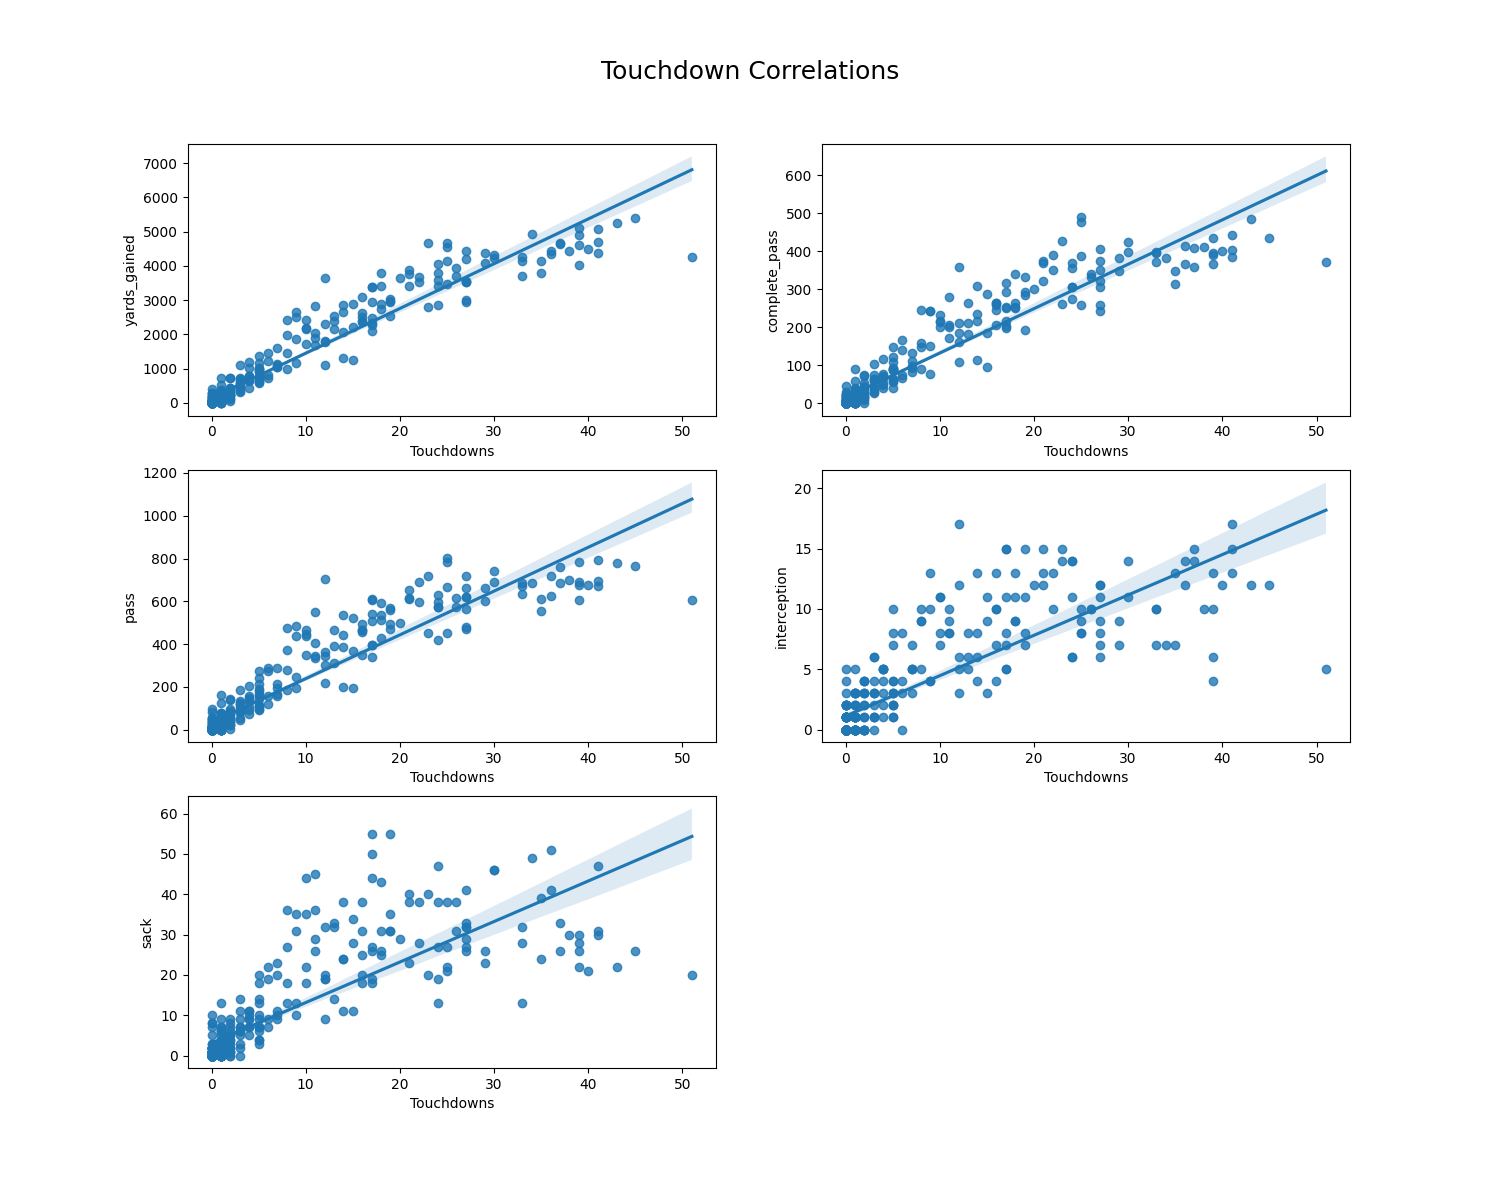

In [10]:
# let's see what correlates with touchdowns 
# list of columns we think correlate to TDs
correlators = ['yards_gained', 'complete_pass', 'pass', 'interception', 'sack']
# set the plot figure
plt.figure(figsize=(15, 12))
# adjust spacing and set subplots title
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Touchdown Correlations", fontsize=18, y=0.95)

# set number of columns (use 2 to demonstrate the change)
ncols = 2
# calculate number of rows
nrows = len(correlators) // ncols + (len(correlators) % ncols > 0)

# loop through the length of our correlators and keep track of index
for n, correlation in enumerate(correlators):
    # add a new subplot iteratively using nrows and cols
    ax = plt.subplot(nrows, ncols, n + 1)
    # plot our data
    sns.regplot(data=qb_df, x='touchdowns', y=correlation)
    # chart formatting
    # ax.set_title("Touchdowns & " + correlation.upper())
    ax.set_xlabel("Touchdowns")
%matplot plt

In [11]:
# Apparently knowing yards gained, 
# completed passes, attempted passes, 
# interceptions, and sacks all correlate with
# touchdowns. Let's see if this is the case for
# _next season_ touchdowns 

# make a copy of the qb dataframe 
_df = qb_df.copy()

# add 1 to season
_df['season'] = _df['season'].add(1)

# example 2019 will now == 2020
# when we add it back down below we're merging on season (2020), passer_id and passer
# we're also adding the _prev suffix to it 
# essentially adding back the 2019 data to the 2020 record as previous

# merge this back on the original qb dataframe
# specify "on=[]" so we only join on specific 
# columns; specify "suffixes=()" so the duplicate
# column names get a suffix appended to them; 
# specify "how='left'" so this is a left join 
new_qb_df = (qb_df
             .merge(_df, 
                    on=['season', 'passer_id', 'passer'], 
                    suffixes=('', '_prev'), 
                    how='left'))

new_qb_df.sample(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     season   passer_id         passer  pass  ...  yards_gained_prev  rush_touchdown_prev  pass_touchdown_prev  touchdowns_prev
126    2021  00-0026143         M.Ryan   652  ...             4430.0                  1.0                 26.0             27.0
161    2021  00-0031941      J.Crowder     2  ...               43.0                  0.0                  1.0              1.0
176    2021  00-0033307       K.Bourne     1  ...                NaN                  NaN                  NaN              NaN
184    2021  00-0033873      P.Mahomes   784  ...             4891.0                  1.0                 38.0             39.0
40     2020  00-0031237  T.Bridgewater   592  ...                NaN                  NaN                  NaN              NaN
235    2021  00-0036946         K.Mond     3  ...                NaN                  NaN                  NaN              NaN
299    2022  00-0034418       C.Wilson     1  ...               88.0                  0.0               

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

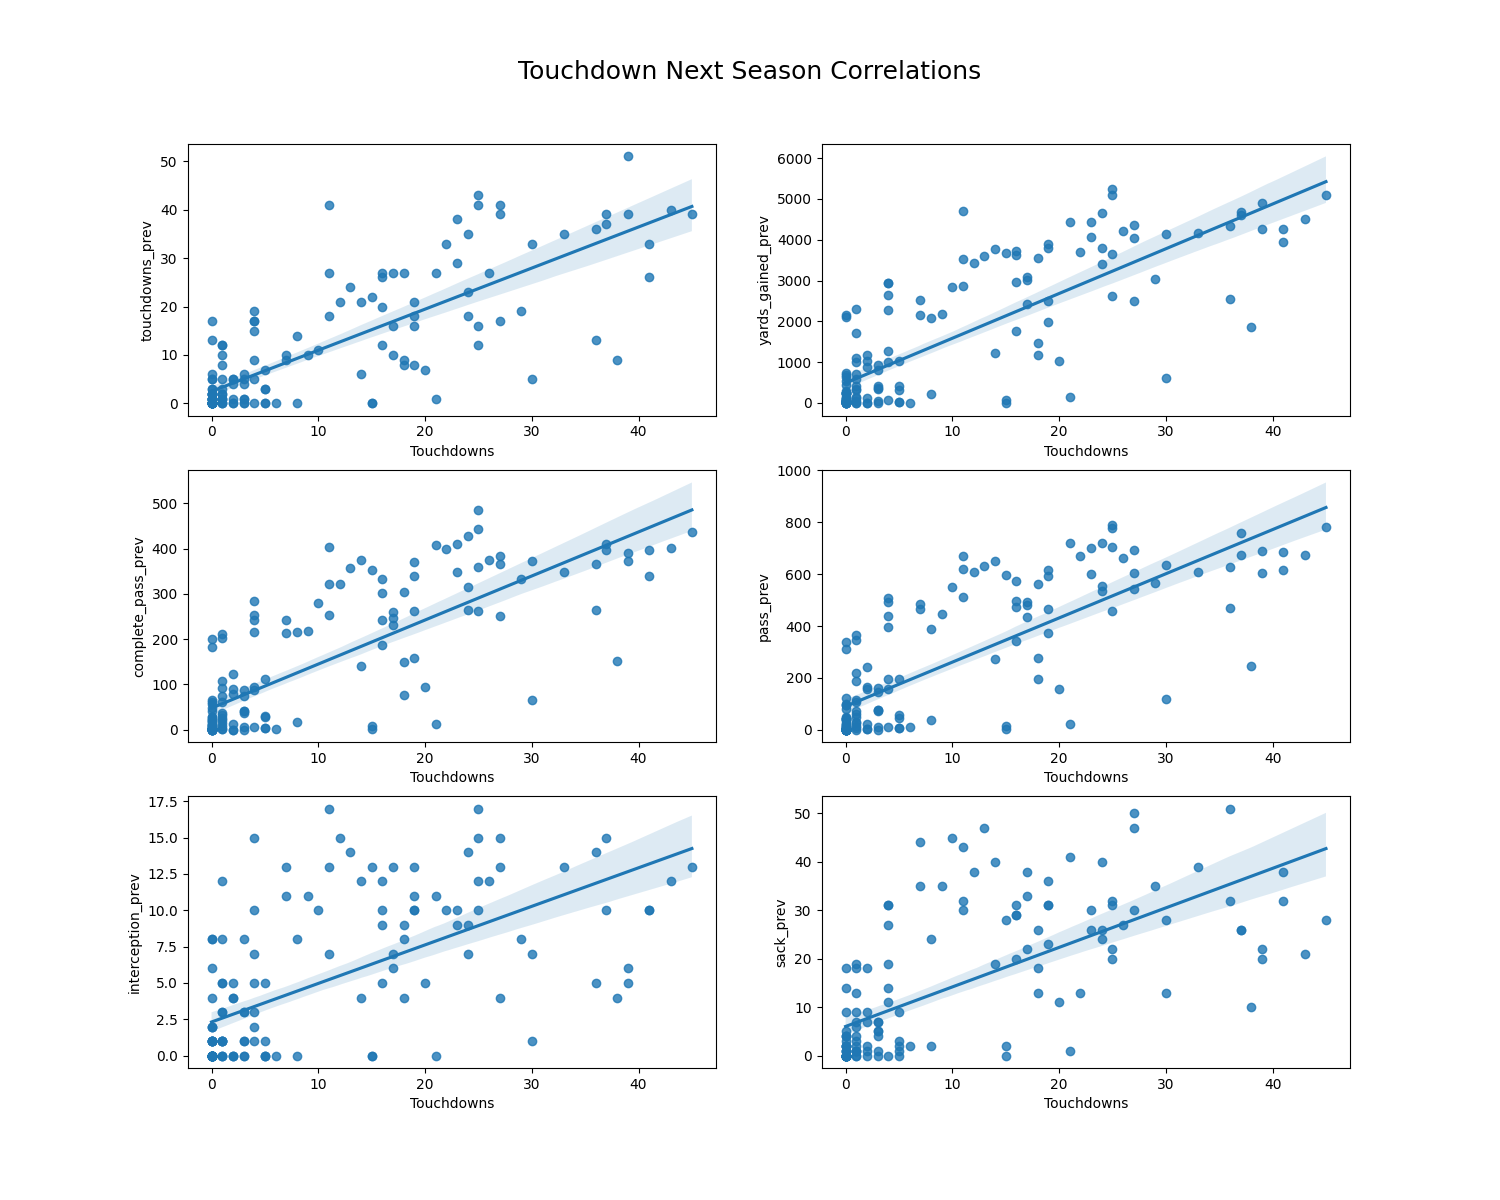

In [12]:
# let's see what correlates with next season touchdowns
# list of columns we think correlate to TDs
correlators = ['touchdowns_prev','yards_gained_prev', 'complete_pass_prev', 'pass_prev', 'interception_prev','sack_prev']
# set the plot figure
plt.figure(figsize=(15, 12))
# adjust spacing and set subplots title
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Touchdown Next Season Correlations", fontsize=18, y=0.95)

# set number of columns (use 3 to demonstrate the change)
ncols = 2
# calculate number of rows
nrows = len(correlators) // ncols + (len(correlators) % ncols > 0)

# loop through the length of our correlators and keep track of index
for n, correlation in enumerate(correlators):
    # add a new subplot iteratively using nrows and cols
    ax = plt.subplot(nrows, ncols, n + 1)
    # plot our data
    sns.regplot(data=new_qb_df, x='touchdowns', y=correlation)
    # chart formatting
    # ax.set_title("Touchdowns & " + correlation.upper())
    ax.set_xlabel("Touchdowns")
%matplot plt

## **Machine Learning**
    * Simple Linear Model
    * Train with the previous year, test on the next year
    * Save out-of-sample-results
    * Visualize and run basic stats

#### Using previous season information, we can see 
#### there are year-to-year correlations with
#### touchdowns. Let's use previous season performance
#### to estimate touchdowns thrown for the next season

In [13]:
# Let's load in machine learning and stats packages
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
new_qb_df.sample(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     season   passer_id         passer  pass  ...  yards_gained_prev  rush_touchdown_prev  pass_touchdown_prev  touchdowns_prev
31     2020  00-0029665  R.Griffin III    20  ...                NaN                  NaN                  NaN              NaN
337    2022  00-0036900        J.Chase     1  ...                NaN                  NaN                  NaN              NaN
268    2022  00-0032156      T.Siemian    29  ...             1112.0                  1.0                 11.0             12.0
27     2020  00-0029000      C.Beasley     1  ...                NaN                  NaN                  NaN              NaN
145    2021  00-0030279        K.Allen     2  ...                0.0                  0.0                  0.0              0.0
187    2021  00-0034052      B.Zylstra     1  ...                NaN                  NaN                  NaN              NaN
153    2021  00-0031280         D.Carr   720  ...             4079.0                  2.0               

In [15]:
# We will "train" our data on one season and "test"
# on the next season. If you are unfamiliar with
# the concept of train test splitting, I suggest 
# codebasics tutorial https://www.youtube.com/watch?v=fwY9Qv96DJY

# Let's use the previous season performance as
# our features for our model 
features = ['pass_prev', 'complete_pass_prev', 
            'interception_prev', 'sack_prev',
            'yards_gained_prev',
            'touchdowns_prev']

# We are predicting "current" season touchdowns 
target = 'touchdowns' 

# Let's make a subset of data that has 
# no null values
model_data = (new_qb_df
              .dropna(subset=features+[target]))

# train on 2021 data  
train_data = (model_data
              .loc[model_data['season']==2021])

# test on 2022 data (data the model hasn't seen)
test_data = (model_data
             .loc[model_data['season']==2022]).copy()

# initialize the linear regression
model = LinearRegression()

# fit, or "train", the model on the training data
model.fit(train_data.loc[:, features], 
          train_data[target])

# predict on the test data 
preds = model.predict(test_data.loc[:, features])

# don't forget to set an index so your 
# predictions match the correct rows
preds = pd.Series(preds, index=test_data.index)

# join your predictions back to your test dataset
test_data['preds'] = preds

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# Let's run some basic statistics to examine the
# quality of the prediction

rmse = mean_squared_error(test_data['touchdowns'], test_data['preds'])**0.5
# RMSE (Root Mean Squared Error) It measures the average difference between values predicted by a model and the actual values
r2 = pearsonr(test_data['touchdowns'], test_data['preds'])[0]**2
# R2 = In the context of regression it is a statistical measure of how well the regression line approximates the actual data
print(f"rmse: {rmse}\nr2: {r2}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rmse: 7.027902225946555
r2: 0.6419511503096903

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

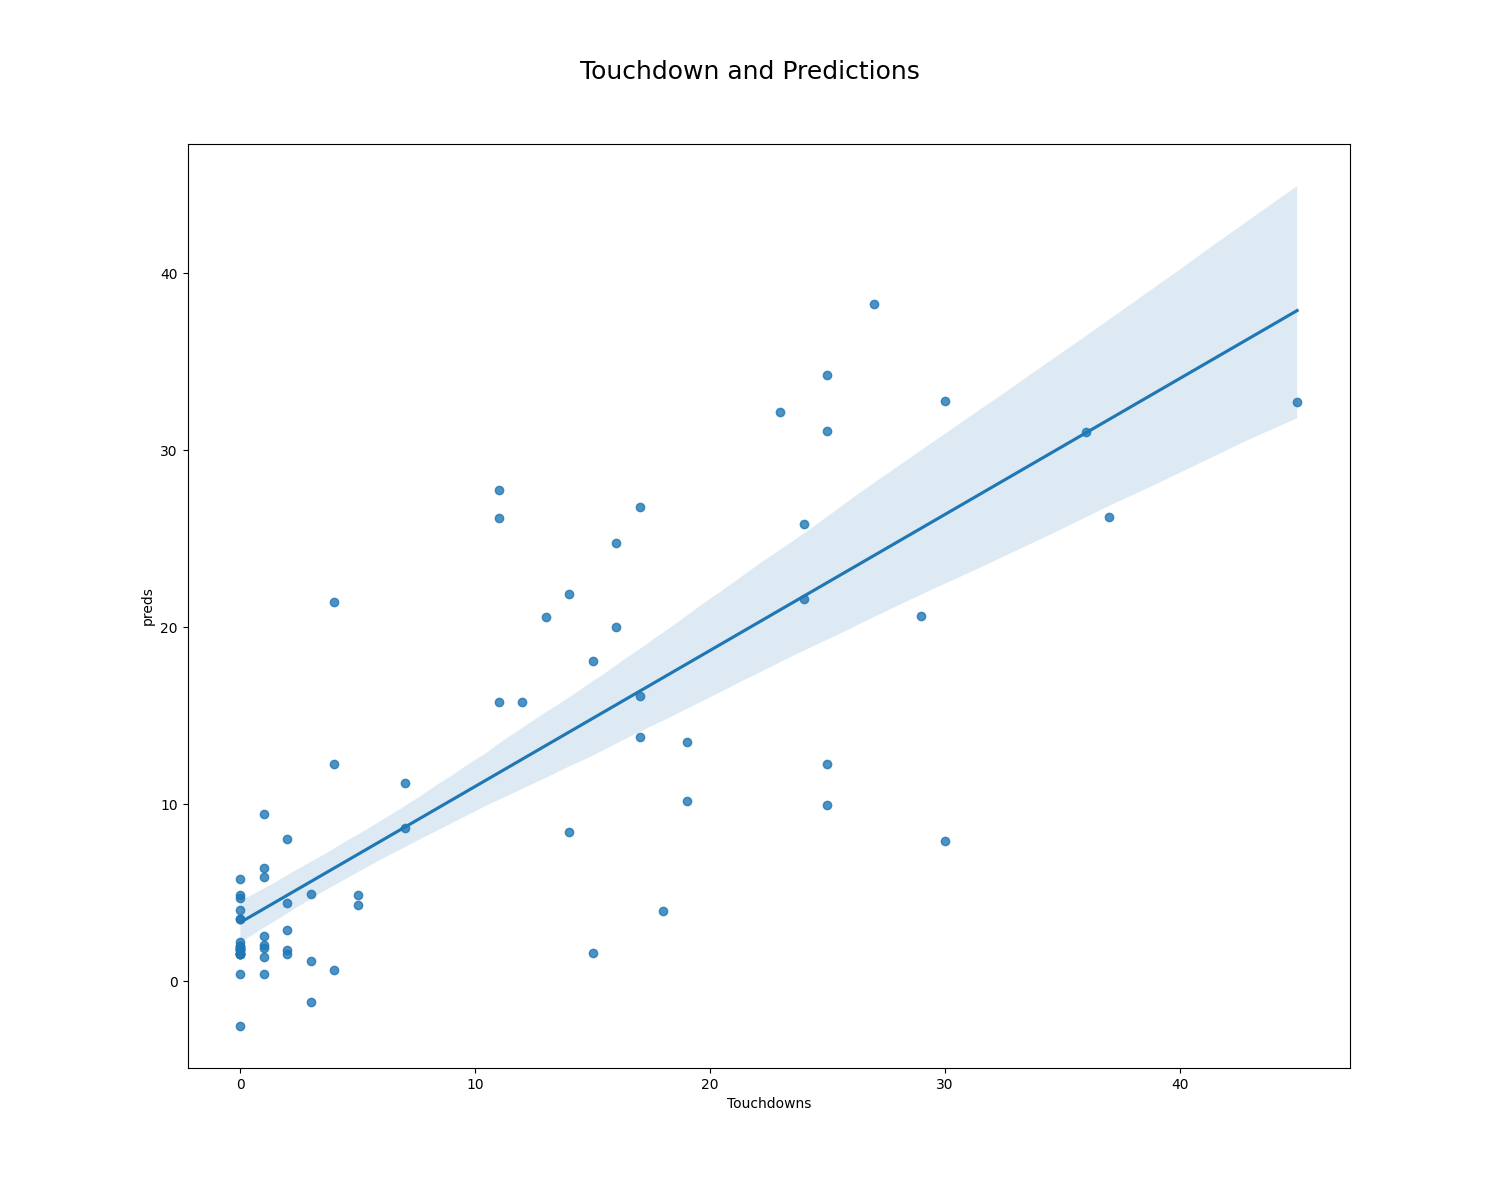

In [17]:
# Let's visualize the outputs 
# sns.regplot(data=test_data, x='touchdown', y='preds')
# plt.title('touchdown and predictions')
# plt.show();
# %matplot plt

# set the plot figure
plt.figure(figsize=(15, 12))
# adjust spacing and set subplots title
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Touchdown and Predictions", fontsize=18, y=0.95)

# set number of columns
ncols = 1
# calculate number of rows
nrows = 1

# add a new subplot iteratively using nrows and cols
ax = plt.subplot(nrows, ncols, 1)
# plot our data
sns.regplot(data=test_data, x='touchdowns', y='preds')
# chart formatting
ax.set_xlabel("Touchdowns")

%matplot plt

In [18]:
test_data.loc[:, ['season', 'passer_id', 'passer','rush_touchdown', 'pass_touchdown','touchdowns', 'preds']].sort_values('touchdowns', ascending=False).head(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     season   passer_id      passer  rush_touchdown  pass_touchdown  touchdowns      preds
291    2022  00-0033873   P.Mahomes             4.0            41.0        45.0  32.711129
305    2022  00-0034857     J.Allen             2.0            35.0        37.0  26.235799
333    2022  00-0036442    J.Burrow             1.0            35.0        36.0  31.009921
257    2022  00-0029604   K.Cousins             1.0            29.0        30.0  32.765709
260    2022  00-0030565     G.Smith             0.0            30.0        30.0   7.916270
279    2022  00-0033106      J.Goff             0.0            29.0        29.0  20.609670
242    2022  00-0023459   A.Rodgers             1.0            26.0        27.0  38.266150
240    2022  00-0019596     T.Brady             0.0            25.0        25.0  34.248553
340    2022  00-0036971  T.Lawrence             0.0            25.0        25.0   9.970243
329    2022  00-0036355   J.Herbert             0.0            25.0        25.0  31.078177